In [1]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K, Sequential, Input, Model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Using TensorFlow backend.


In [2]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    
    Also note that we calculate f1 without using the results method
    in keras_model. This is because we need to check beforehand that
    computing f1 won't produce a NaN so we won't get an invalid value warning.
    '''
    
    #error is occuring in km.results when computing f1, because TNR, NPV are 0, implying that there
    #are no true negatives. While we added if statements to account for at least one predicted
    #negative, this does not correlate to at least one true negative. Hence, instead of using keras.results
    #we use that code by check that tn is not 0
    f1_vals = []
    for i in range(0, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

        cm = confusion_matrix(y_real, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
        
        if tn != 0:      
            TNR = (tn) / (tn + fp)
            NPV = (tn) / (tn + fn)
            f1 = 2 * (TNR * NPV) / (TNR + NPV)
        else:
            f1 = -2   
        f1_vals.append(f1)
        
    f1_vals = np.array(f1_vals)
    f1_vals = np.nan_to_num(f1_vals, nan=-1)
    return (np.argmax(f1_vals))/100

In [3]:
def plot_confusion_matrix(y_real, y_predict):
    '''
    Given y_real and y_predict, this method displays the results
    (accuracy, recall, precision, f1) followed by the plot of the confusion matrix.
    '''
    print(km.results(y_real, y_predict), '\n')
    
    classes = ['High_svi', 'Low_svi']
    cm = confusion_matrix(y_real, y_predict)
    sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [4]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [5]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [6]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [7]:
reactor_list[2]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,94.066570,22.030,0.22,2.92
2010-01-02,95.318860,21.985,0.22,3.04
2010-01-03,82.826748,21.740,0.22,3.00
2010-01-04,95.307918,21.815,0.22,2.97
2010-01-05,93.930636,21.890,0.23,2.94
...,...,...,...,...
2020-12-27,144.736842,22.540,0.23,3.41
2020-12-28,130.890052,22.535,0.24,3.10
2020-12-29,140.306122,22.660,0.25,3.15


In [8]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [9]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [10]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [11]:
join_list[1]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,88.649852,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,86.480363,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,96.370968,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,109.427609,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,100.929054,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.887324,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,152.173913,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)

In [13]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 70.93it/s]


In [14]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

In [15]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Epoch 1/3
14439/14439 [==============================] - 15s 1ms/step - loss: 0.5811 - binary_accuracy: 0.6827
Epoch 2/3
14439/14439 [==============================] - 13s 918us/step - loss: 0.4502 - binary_accuracy: 0.7281
Epoch 3/3
14439/14439 [==============================] - 12s 831us/step - loss: 0.4287 - binary_accuracy: 0.7552


In [16]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)

In [17]:
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

In [18]:
threshold

0.87

(0.8043613707165109, 0.771484375, 0.6672297297297297, 0.7155797101449275) 

Confusion matrix, without normalization
[[395 117]
 [197 896]]


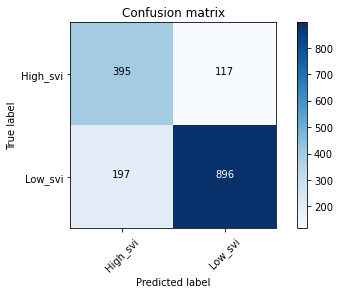

In [19]:
plot_confusion_matrix(y_real, y_predict)

In [20]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [21]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)

100%|██████████| 7/7 [00:00<00:00, 71.03it/s]


In [22]:
auc(fpr, tpr)

0.8794262494281794

In [23]:
X_normalize = np.nan_to_num(X_normalize, nan=-1)

Text(0.5, 1.0, 'ROC curve')

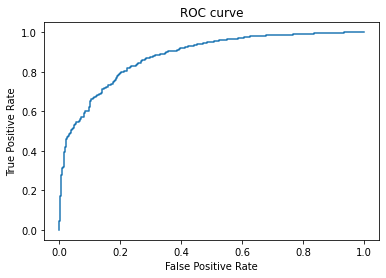

In [24]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [25]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #this block of code is because some models (like 6) require steps_in start at 3 instead of 1
    shift_vals = {1: 1,
                  3: 1,
                  6: 3,
                  9: 2}
    shift_val = shift_vals[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-shift_val):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-shift_val):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+shift_val} ")
        plt.savefig(f"figures/{model_name} n_steps_in={z+shift_val}.png", bbox_inches="tight")
        plt.close()

In [26]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(25, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6 - having lots of trouble with this one
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

def train_GRU_CNN_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(2, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)            
            
            inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
            x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
            x = AveragePooling1D(2)(x)
            x = Conv1D(100, 3, activation='relu', padding='same',
                       name='extractor')(x)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            x = Dropout(0.5)(x)

            out = Dense(1, activation="sigmoid")(x)

            model = Model(inp_seq, out)

            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list
    pass

In [ ]:
#Code to run models
list_of_result_lists = {}
models_list = [1]

epochs = 10
steps_in = 10
steps_out = 10


steps_in += 1
steps_out += 1

for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

100%|██████████| 1/1 [00:00<00:00, 668.84it/s]


Epoch 1/10
12854/12854 [==============================] - 6s 465us/step - loss: 0.6476
Epoch 2/10
12854/12854 [==============================] - 5s 390us/step - loss: 0.6140
Epoch 3/10
12854/12854 [==============================] - 5s 419us/step - loss: 0.5936
Epoch 4/10
12854/12854 [==============================] - 5s 399us/step - loss: 0.5619
Epoch 5/10
12854/12854 [==============================] - 4s 296us/step - loss: 0.5270
Epoch 6/10
12854/12854 [==============================] - 4s 292us/step - loss: 0.4961
Epoch 7/10
12854/12854 [==============================] - 4s 287us/step - loss: 0.4716
Epoch 8/10
12854/12854 [==============================] - 4s 287us/step - loss: 0.4535
Epoch 9/10
12854/12854 [==============================] - 4s 282us/step - loss: 0.4406
Epoch 10/10
12854/12854 [==============================] - 4s 283us/step - loss: 0.4319


100%|██████████| 1/1 [00:00<00:00, 690.53it/s]


Epoch 1/10
12851/12851 [==============================] - 5s 406us/step - loss: 0.6455
Epoch 2/10
12851/12851 [==============================] - 4s 286us/step - loss: 0.5997
Epoch 3/10
12851/12851 [==============================] - 4s 285us/step - loss: 0.5590
Epoch 4/10
12851/12851 [==============================] - 4s 317us/step - loss: 0.5209
Epoch 5/10
12851/12851 [==============================] - 4s 299us/step - loss: 0.4932
Epoch 6/10
12851/12851 [==============================] - 4s 285us/step - loss: 0.4745
Epoch 7/10
12851/12851 [==============================] - 4s 319us/step - loss: 0.4629
Epoch 8/10
12851/12851 [==============================] - 4s 301us/step - loss: 0.4556
Epoch 9/10
12851/12851 [==============================] - 4s 288us/step - loss: 0.4512
Epoch 10/10
12851/12851 [==============================] - 4s 287us/step - loss: 0.4479


100%|██████████| 1/1 [00:00<00:00, 688.27it/s]


Epoch 1/10
12848/12848 [==============================] - 5s 401us/step - loss: 0.6501
Epoch 2/10
12848/12848 [==============================] - 4s 285us/step - loss: 0.6189
Epoch 3/10
12848/12848 [==============================] - 4s 280us/step - loss: 0.6038
Epoch 4/10
12848/12848 [==============================] - 4s 281us/step - loss: 0.5823
Epoch 5/10
12848/12848 [==============================] - 4s 279us/step - loss: 0.5574
Epoch 6/10
12848/12848 [==============================] - 4s 279us/step - loss: 0.5342
Epoch 7/10
12848/12848 [==============================] - 4s 279us/step - loss: 0.5146
Epoch 8/10
12848/12848 [==============================] - 4s 280us/step - loss: 0.4990
Epoch 9/10
12848/12848 [==============================] - 4s 279us/step - loss: 0.4880
Epoch 10/10
12848/12848 [==============================] - 4s 280us/step - loss: 0.4797


100%|██████████| 1/1 [00:00<00:00, 805.82it/s]


Epoch 1/10
12844/12844 [==============================] - 5s 403us/step - loss: 0.6546
Epoch 2/10
12844/12844 [==============================] - 4s 315us/step - loss: 0.6118
Epoch 3/10
12844/12844 [==============================] - 4s 300us/step - loss: 0.5905
Epoch 4/10
12844/12844 [==============================] - 4s 283us/step - loss: 0.5659
Epoch 5/10
12844/12844 [==============================] - 4s 283us/step - loss: 0.5428
Epoch 6/10
12844/12844 [==============================] - 4s 284us/step - loss: 0.5244
Epoch 7/10
12844/12844 [==============================] - 4s 282us/step - loss: 0.5100
Epoch 8/10
12844/12844 [==============================] - 4s 287us/step - loss: 0.4987
Epoch 9/10
12844/12844 [==============================] - 4s 283us/step - loss: 0.4905
Epoch 10/10
12844/12844 [==============================] - 4s 282us/step - loss: 0.4844


100%|██████████| 1/1 [00:00<00:00, 727.80it/s]


Epoch 1/10
12841/12841 [==============================] - 5s 403us/step - loss: 0.6629
Epoch 2/10
12841/12841 [==============================] - 4s 339us/step - loss: 0.6127
Epoch 3/10
12841/12841 [==============================] - 5s 360us/step - loss: 0.5786
Epoch 4/10
12841/12841 [==============================] - 4s 283us/step - loss: 0.5467
Epoch 5/10
12841/12841 [==============================] - 4s 283us/step - loss: 0.5236
Epoch 6/10
12841/12841 [==============================] - 4s 278us/step - loss: 0.5080
Epoch 7/10
12841/12841 [==============================] - 4s 281us/step - loss: 0.4983
Epoch 8/10
12841/12841 [==============================] - 4s 279us/step - loss: 0.4915
Epoch 9/10
12841/12841 [==============================] - 4s 285us/step - loss: 0.4872
Epoch 10/10
12841/12841 [==============================] - 4s 279us/step - loss: 0.4847


100%|██████████| 1/1 [00:00<00:00, 546.70it/s]


Epoch 1/10
12838/12838 [==============================] - 5s 391us/step - loss: 0.6466
Epoch 2/10
12838/12838 [==============================] - 4s 279us/step - loss: 0.6156
Epoch 3/10
12838/12838 [==============================] - 4s 275us/step - loss: 0.5969
Epoch 4/10
12838/12838 [==============================] - 4s 288us/step - loss: 0.5735
Epoch 5/10
12838/12838 [==============================] - 4s 287us/step - loss: 0.5513
Epoch 6/10
12838/12838 [==============================] - 4s 277us/step - loss: 0.5332
Epoch 7/10
12838/12838 [==============================] - 4s 275us/step - loss: 0.5200
Epoch 8/10
12838/12838 [==============================] - 4s 279us/step - loss: 0.5101
Epoch 9/10
12838/12838 [==============================] - 4s 276us/step - loss: 0.5030
Epoch 10/10
12838/12838 [==============================] - 4s 304us/step - loss: 0.4984


100%|██████████| 1/1 [00:00<00:00, 825.16it/s]


Epoch 1/10
12835/12835 [==============================] - 5s 408us/step - loss: 0.6499
Epoch 2/10
12835/12835 [==============================] - 5s 418us/step - loss: 0.6210
Epoch 3/10
12835/12835 [==============================] - 4s 294us/step - loss: 0.6099
Epoch 4/10
12835/12835 [==============================] - 4s 339us/step - loss: 0.5936
Epoch 5/10
12835/12835 [==============================] - 5s 398us/step - loss: 0.5761
Epoch 6/10
12835/12835 [==============================] - 5s 367us/step - loss: 0.5582
Epoch 7/10
12835/12835 [==============================] - 4s 293us/step - loss: 0.5436
Epoch 8/10
12835/12835 [==============================] - 4s 290us/step - loss: 0.5321
Epoch 9/10
12835/12835 [==============================] - 4s 310us/step - loss: 0.5229
Epoch 10/10
12835/12835 [==============================] - 4s 291us/step - loss: 0.5150


100%|██████████| 1/1 [00:00<00:00, 758.74it/s]


Epoch 1/10
12832/12832 [==============================] - 5s 425us/step - loss: 0.6472
Epoch 2/10
12832/12832 [==============================] - 4s 278us/step - loss: 0.6146
Epoch 3/10
12832/12832 [==============================] - 4s 279us/step - loss: 0.5960
Epoch 4/10
12832/12832 [==============================] - 4s 277us/step - loss: 0.5766
Epoch 5/10
12832/12832 [==============================] - 4s 278us/step - loss: 0.5597
Epoch 6/10
12832/12832 [==============================] - 4s 299us/step - loss: 0.5461
Epoch 7/10
12832/12832 [==============================] - 4s 347us/step - loss: 0.5353
Epoch 8/10
12832/12832 [==============================] - 4s 339us/step - loss: 0.5271
Epoch 9/10
12832/12832 [==============================] - 4s 327us/step - loss: 0.5205
Epoch 10/10
12832/12832 [==============================] - 5s 352us/step - loss: 0.5156


100%|██████████| 1/1 [00:00<00:00, 482.38it/s]


Epoch 1/10
12828/12828 [==============================] - 6s 442us/step - loss: 0.6402
Epoch 2/10
12828/12828 [==============================] - 4s 293us/step - loss: 0.6100
Epoch 3/10
12828/12828 [==============================] - 4s 327us/step - loss: 0.5891
Epoch 4/10
12828/12828 [==============================] - 4s 339us/step - loss: 0.5691
Epoch 5/10
12828/12828 [==============================] - 5s 363us/step - loss: 0.5529
Epoch 6/10
12828/12828 [==============================] - 4s 318us/step - loss: 0.5410
Epoch 7/10
12828/12828 [==============================] - 4s 326us/step - loss: 0.5321
Epoch 8/10
12828/12828 [==============================] - 4s 343us/step - loss: 0.5259
Epoch 9/10
12828/12828 [==============================] - 6s 483us/step - loss: 0.5213
Epoch 10/10
12828/12828 [==============================] - 4s 297us/step - loss: 0.5181


100%|██████████| 2/2 [00:00<00:00, 724.84it/s]


Epoch 1/10
12851/12851 [==============================] - 6s 480us/step - loss: 0.6345
Epoch 2/10
12851/12851 [==============================] - 5s 371us/step - loss: 0.5727
Epoch 3/10
12851/12851 [==============================] - 5s 374us/step - loss: 0.5035
Epoch 4/10
12851/12851 [==============================] - 7s 524us/step - loss: 0.4555
Epoch 5/10
12851/12851 [==============================] - 5s 408us/step - loss: 0.4333
Epoch 6/10
12851/12851 [==============================] - 5s 399us/step - loss: 0.4261
Epoch 7/10
12851/12851 [==============================] - 5s 392us/step - loss: 0.4193
Epoch 8/10
12851/12851 [==============================] - 5s 404us/step - loss: 0.4151
Epoch 9/10
12851/12851 [==============================] - 5s 399us/step - loss: 0.4138
Epoch 10/10
12851/12851 [==============================] - 5s 400us/step - loss: 0.4137


100%|██████████| 2/2 [00:00<00:00, 592.96it/s]


Epoch 1/10
12848/12848 [==============================] - 6s 496us/step - loss: 0.6407
Epoch 2/10
12848/12848 [==============================] - 5s 412us/step - loss: 0.5930
Epoch 3/10
12848/12848 [==============================] - 5s 425us/step - loss: 0.5331
Epoch 4/10
12848/12848 [==============================] - 5s 396us/step - loss: 0.4830
Epoch 5/10
12848/12848 [==============================] - 6s 438us/step - loss: 0.4619
Epoch 6/10
12848/12848 [==============================] - 5s 386us/step - loss: 0.4510
Epoch 7/10
12848/12848 [==============================] - 6s 440us/step - loss: 0.4454
Epoch 8/10
12848/12848 [==============================] - 5s 396us/step - loss: 0.4420
Epoch 9/10
12848/12848 [==============================] - 5s 374us/step - loss: 0.4414
Epoch 10/10
12848/12848 [==============================] - 6s 452us/step - loss: 0.4379


100%|██████████| 2/2 [00:00<00:00, 450.06it/s]


Epoch 1/10
12844/12844 [==============================] - 9s 664us/step - loss: 0.6465
Epoch 2/10
12844/12844 [==============================] - 5s 400us/step - loss: 0.5981
Epoch 3/10
12844/12844 [==============================] - 5s 394us/step - loss: 0.5449
Epoch 4/10
12844/12844 [==============================] - 5s 425us/step - loss: 0.5029
Epoch 5/10
12844/12844 [==============================] - 5s 421us/step - loss: 0.4782
Epoch 6/10
12844/12844 [==============================] - 6s 436us/step - loss: 0.4673
Epoch 7/10
12844/12844 [==============================] - 6s 440us/step - loss: 0.4602
Epoch 8/10
12844/12844 [==============================] - 6s 467us/step - loss: 0.4557
Epoch 9/10
12844/12844 [==============================] - 7s 507us/step - loss: 0.4558
Epoch 10/10
12844/12844 [==============================] - 5s 428us/step - loss: 0.4519


100%|██████████| 2/2 [00:00<00:00, 586.00it/s]


Epoch 1/10
12841/12841 [==============================] - 6s 497us/step - loss: 0.6389
Epoch 2/10
12841/12841 [==============================] - 5s 422us/step - loss: 0.5893
Epoch 3/10
12841/12841 [==============================] - 5s 424us/step - loss: 0.5390
Epoch 4/10
12841/12841 [==============================] - 7s 563us/step - loss: 0.5044
Epoch 5/10
12841/12841 [==============================] - 7s 571us/step - loss: 0.4836
Epoch 6/10
12841/12841 [==============================] - 5s 418us/step - loss: 0.4733
Epoch 7/10
12841/12841 [==============================] - 5s 365us/step - loss: 0.4678
Epoch 8/10
12841/12841 [==============================] - 5s 369us/step - loss: 0.4634
Epoch 9/10
12841/12841 [==============================] - 5s 368us/step - loss: 0.4615
Epoch 10/10
12841/12841 [==============================] - 6s 450us/step - loss: 0.4608


100%|██████████| 2/2 [00:00<00:00, 674.05it/s]


Epoch 1/10
12838/12838 [==============================] - 7s 511us/step - loss: 0.6399
Epoch 2/10
12838/12838 [==============================] - 6s 466us/step - loss: 0.5909
Epoch 3/10
12838/12838 [==============================] - 5s 405us/step - loss: 0.5451
Epoch 4/10
12838/12838 [==============================] - 5s 383us/step - loss: 0.5101
Epoch 5/10
12838/12838 [==============================] - 5s 417us/step - loss: 0.4912
Epoch 6/10
12838/12838 [==============================] - 5s 362us/step - loss: 0.4811
Epoch 7/10
12838/12838 [==============================] - 5s 362us/step - loss: 0.4761
Epoch 8/10
12838/12838 [==============================] - 5s 360us/step - loss: 0.4734
Epoch 9/10
12838/12838 [==============================] - 5s 373us/step - loss: 0.4727
Epoch 10/10
12838/12838 [==============================] - 5s 414us/step - loss: 0.4709


100%|██████████| 2/2 [00:00<00:00, 706.77it/s]


Epoch 1/10
12835/12835 [==============================] - 6s 505us/step - loss: 0.6318
Epoch 2/10
12835/12835 [==============================] - 5s 369us/step - loss: 0.5904
Epoch 3/10
12835/12835 [==============================] - 5s 370us/step - loss: 0.5530
Epoch 4/10
12835/12835 [==============================] - 5s 376us/step - loss: 0.5204
Epoch 5/10
12835/12835 [==============================] - 5s 395us/step - loss: 0.4996
Epoch 6/10
12835/12835 [==============================] - 5s 381us/step - loss: 0.4890
Epoch 7/10
12835/12835 [==============================] - 5s 384us/step - loss: 0.4833
Epoch 8/10
12835/12835 [==============================] - 5s 411us/step - loss: 0.4805
Epoch 9/10
12835/12835 [==============================] - 5s 408us/step - loss: 0.4774
Epoch 10/10
12835/12835 [==============================] - 5s 414us/step - loss: 0.4765


100%|██████████| 2/2 [00:00<00:00, 636.37it/s]


Epoch 1/10
12832/12832 [==============================] - 7s 541us/step - loss: 0.6357
Epoch 2/10
12832/12832 [==============================] - 6s 477us/step - loss: 0.5936
Epoch 3/10
12832/12832 [==============================] - 6s 448us/step - loss: 0.5583
Epoch 4/10
12832/12832 [==============================] - 5s 388us/step - loss: 0.5283
Epoch 5/10
12832/12832 [==============================] - 5s 413us/step - loss: 0.5104
Epoch 6/10
12832/12832 [==============================] - 5s 376us/step - loss: 0.4998
Epoch 7/10
12832/12832 [==============================] - 6s 433us/step - loss: 0.4938
Epoch 8/10
12832/12832 [==============================] - 5s 390us/step - loss: 0.4920
Epoch 9/10
12832/12832 [==============================] - 5s 404us/step - loss: 0.4904
Epoch 10/10
12832/12832 [==============================] - 6s 439us/step - loss: 0.4879


100%|██████████| 2/2 [00:00<00:00, 616.31it/s]


Epoch 1/10
12828/12828 [==============================] - 8s 585us/step - loss: 0.6396
Epoch 2/10
12828/12828 [==============================] - 5s 382us/step - loss: 0.6052
Epoch 3/10
12828/12828 [==============================] - 5s 371us/step - loss: 0.5766
Epoch 4/10
12828/12828 [==============================] - 5s 384us/step - loss: 0.5502
Epoch 5/10
12828/12828 [==============================] - 6s 435us/step - loss: 0.5284
Epoch 6/10
12828/12828 [==============================] - 5s 385us/step - loss: 0.5129
Epoch 7/10
12828/12828 [==============================] - 5s 406us/step - loss: 0.5057
Epoch 8/10
12828/12828 [==============================] - 5s 411us/step - loss: 0.5016
Epoch 9/10
12828/12828 [==============================] - 5s 402us/step - loss: 0.4985
Epoch 10/10
12828/12828 [==============================] - 5s 388us/step - loss: 0.4968


100%|██████████| 2/2 [00:00<00:00, 809.09it/s]


Epoch 1/10
12825/12825 [==============================] - 6s 500us/step - loss: 0.6383
Epoch 2/10
11770/12825 [==========================>...] - ETA: 0s - loss: 0.6024

In [ ]:
results_list

In [ ]:
list_of_result_lists

In [ ]:
# list_of_result_lists[6]